# DETECTING SPAM EMAILS USING TENSORFLOW

In [33]:
# Importing Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import string
import nltk
from nltk.corpus import stopwords
from wordcloud import WordCloud
nltk.download('stopwords')

# Importing libraries necesary for Model Building and training
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

import warnings
warnings.filterwarnings('ignore')

[nltk_data] Error loading stopwords: <urlopen error [Errno 11001]
[nltk_data]     getaddrinfo failed>


In [34]:
#Checking the Version of tensor flow that I have
tf. __version__

'2.15.0'

### Loading The data set.


In [35]:
data = pd.read_csv("F:\machine learning projects\CLASSIFICATION\P04\spam.csv").dropna(axis = 1)
data.head()

,v1,v2
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [36]:
data.shape

(5572, 2)

Now lets plot this to understand  better

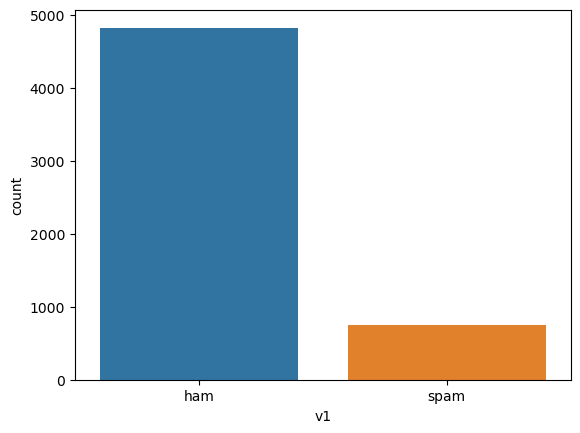

In [37]:
sns.countplot(x = 'v1', data=data)
plt.show()

we can creally see that Ham is much more than that of spam which implies we have an imbalanced dataset.

change the column labels like:

    - v1 = spam
    - v2 = text

In [38]:
data.rename(columns ={'v1' : 'spam',
                      'v2' : 'text'}, inplace = True)
data.head()

,spam,text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


## converting the spam column ito 1 and 0:

    - spam = 1
    - ham = 0

In [39]:
def convert(spam_text):
    if spam_text == 'spam':
        return 1
    elif spam_text == 'ham':
        return 0
    else:
        return None

data['spam'] = data['spam'].apply(convert)
data.head()

,spam,text
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."


### Downsampling to Balance the dataset

In [40]:
ham_msg = data[data.spam == 0]
spam_msg = data[data.spam == 1]

ham_msg = ham_msg.sample(n=len(spam_msg),random_state = 42)


balanced_data =pd.concat([ham_msg, spam_msg]).reset_index(drop=True)
balanced_data.head()


,spam,text
0,0,"I am late,so call you tomorrow morning.take ca..."
1,0,U r too much close to my heart. If u go away i...
2,0,Wait &lt;#&gt; min..
3,0,Can you call me plz. Your number shows out of ...
4,0,MAYBE IF YOU WOKE UP BEFORE FUCKING 3 THIS WOU...


Text(0.5, 0, 'message types')

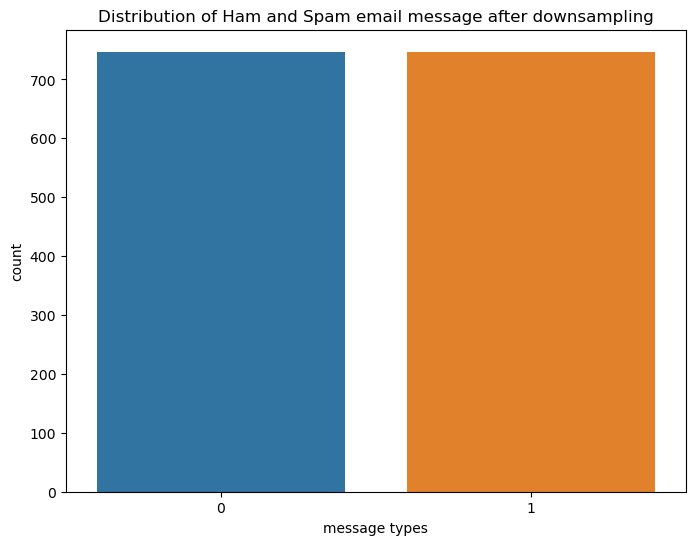

In [41]:
# Plotting the counts of down sampled dataset
plt.figure(figsize=(8,6))
sns.countplot( x='spam', data = balanced_data,)
plt.title("Distribution of Ham and Spam email message after downsampling")
plt.xlabel('message types')


The above shows the distribution of spam and hap after downsampling, we seem to be okay now.

## Text Processing
the textual data is highly Unstructured and need to be inspected

    - stopwords Removal
    - Punctuation Removal
    - Stemming or lemmatization

this might Couse lose of data but its necessary for Better Model Performances.

In [42]:
balanced_data['text'] = balanced_data['text'].str.replace('subject', '')
balanced_data.head()

,spam,text
0,0,"I am late,so call you tomorrow morning.take ca..."
1,0,U r too much close to my heart. If u go away i...
2,0,Wait &lt;#&gt; min..
3,0,Can you call me plz. Your number shows out of ...
4,0,MAYBE IF YOU WOKE UP BEFORE FUCKING 3 THIS WOU...


In [43]:
punctuations_list = string.punctuation
def remove_punctuations(text):
    temp = str.maketrans('','',punctuations_list)
    return text.translate(temp)

balanced_data['text'] = balanced_data['text'].apply(lambda x: remove_punctuations(x))
balanced_data.head()

,spam,text
0,0,I am lateso call you tomorrow morningtake care...
1,0,U r too much close to my heart If u go away i ...
2,0,Wait ltgt min
3,0,Can you call me plz Your number shows out of c...
4,0,MAYBE IF YOU WOKE UP BEFORE FUCKING 3 THIS WOU...


### fuction below will help in eliminating sto words

In [44]:
def remove_stopwords(text):
    stop_words = stopwords.words('english')

    imp_words = []

    # Storing the important words
    for word in str(text).split():
        word = word.lower()

        if word not in stop_words:
            imp_words.append(word)

    output = " ".join(imp_words)
    return output

balanced_data['text'] = balanced_data['text'].apply(lambda text: remove_stopwords(text))
balanced_data.head()

,spam,text
0,0,lateso call tomorrow morningtake care sweet dr...
1,0,u r much close heart u go away shattered plz stay
2,0,wait ltgt min
3,0,call plz number shows coveragd area urgnt call...
4,0,maybe woke fucking 3 wouldnt problem


### *Word Cloud* is a text visualization tool.
it helps us in getting insights into the most frequesnt words present in the data.

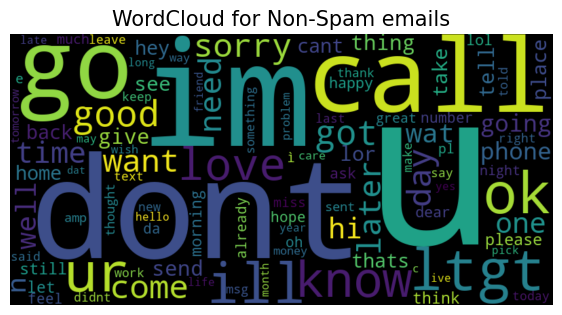

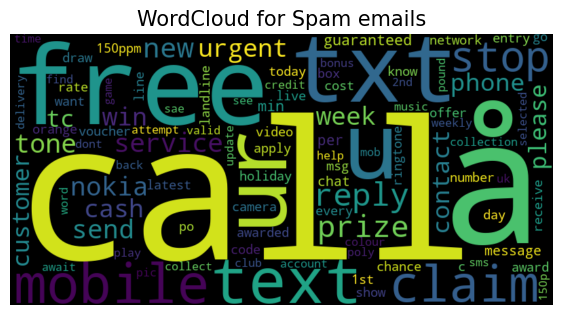

In [45]:

def plot_word_cloud(data, typ):
    email_corpus = " ".join(data['text'])

    plt.figure(figsize =(7,7))

    wc = WordCloud(background_color = 'black',
                  max_words = 100,
                  width = 800,
                  height = 400,
                  collocations = False).generate(email_corpus)
    plt.imshow(wc, interpolation = 'bilinear')
    plt.title(f"WordCloud for {typ} emails", fontsize=15)
    plt.axis('Off')
    plt.show()


plot_word_cloud(balanced_data[balanced_data['spam'] == 0], typ='Non-Spam')
plot_word_cloud(balanced_data[balanced_data['spam'] == 1], typ='Spam')

### Word2Vec Conversion

In [46]:
# Train Test split

train_X, test_X, train_Y, test_Y = train_test_split(balanced_data['text'],
                                                   balanced_data['spam'],
                                                   test_size = 0.2,
                                                   random_state = 42)

we have fitted the tokenizer on our Training data we will use it to convert the training and validation data both to vectors.

### Tokenize the text data.

In [47]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_X)

### Convert text to sequences

In [48]:
train_sequences = tokenizer.texts_to_sequences(train_X)
text_sequences = tokenizer.texts_to_sequences(test_X)

### Pad sequence to have the same length

In [49]:
max_len = 100 # maximum sequence length
train_sequences = pad_sequences(train_sequences,
                               maxlen = max_len,
                               padding = 'post',
                               truncating ='post')

test_sequences = pad_sequences(text_sequences,
                               maxlen = max_len,
                               padding = 'post',
                               truncating = 'post')


## Model Development And Evaluation

we will implement a *Sequential Model* which will contain the following parts:

    - three *Embedding* layers to learn featured vector representations of the input vectors.
    - An *LSTM* layer to indentify useful pattern in the sequence.
    - Then we will have one fully connected layer.
    - The final layer is the output layer which outputs probabilities for the two classes.

In [50]:
# Build the Model
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Embedding(input_dim = len(tokenizer.word_index) +1,
                                    output_dim = 32,
                                    input_length =max_len))
model.add(tf.keras.layers.LSTM(16))
model.add(tf.keras.layers.Dense(32, activation ='relu'))
model.add(tf.keras.layers.Dense(1, activation ='sigmoid'))

# Print the Model summary
model.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 100, 32)           129984    
                                                                 
 lstm_1 (LSTM)               (None, 16)                3136      
                                                                 
 dense_2 (Dense)             (None, 32)                544       
                                                                 
 dense_3 (Dense)             (None, 1)                 33        
                                                                 
Total params: 133697 (522.25 KB)
Trainable params: 133697 (522.25 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


### while compiling a model we provide these three essential parameters:

    -Optimizer - THis is the model that helps to Optimize the cost function by using gradient descent.
    - Loss - The loss Function by which we monitor whether the model is improving with training or not.
    - Metrics - This helps to evaluate the model by Predicting the training and the validation data.

In [51]:
model.compile(loss = tf.keras.losses.BinaryCrossentropy(from_logits = True),
              metrics = ['accuracy'],
              optimizer = 'adam')

### CALLBACK
WE do this to check whether the model is improving  with each epoch or not.. if not I will use steps like ReduceLROnPlateau to decreases the learning rate further, and if the model is not improving we will have to stop the model by EarlyStopping.

In [71]:
es = EarlyStopping(patience = 6,
                   monitor = 'val_accuracy',
                   restore_best_weights = True)

lr = ReduceLROnPlateau(patience = 2,
                       monitor = 'val_loss',
                       factor = 0.5,
                       verbose = 0)


## Training The Model

In [74]:
history = model.fit(train_sequences, train_Y, validation_data=(test_sequences, test_Y),
                    epochs = 20,
                    batch_size = 32,
                    callbacks = [lr,es])

Epoch 1/20
38/38 [==============================] - 1s 25ms/step - loss: 0.6932 - accuracy: 0.4962 - val_loss: 0.6931 - val_accuracy: 0.5151 - lr: 2.6844e-28
Epoch 2/20
38/38 [==============================] - 1s 25ms/step - loss: 0.6932 - accuracy: 0.4962 - val_loss: 0.6931 - val_accuracy: 0.5151 - lr: 2.6844e-28
Epoch 3/20
38/38 [==============================] - 1s 27ms/step - loss: 0.6932 - accuracy: 0.4962 - val_loss: 0.6931 - val_accuracy: 0.5151 - lr: 2.6844e-28
Epoch 4/20
38/38 [==============================] - 1s 24ms/step - loss: 0.6932 - accuracy: 0.4962 - val_loss: 0.6931 - val_accuracy: 0.5151 - lr: 1.3422e-28
Epoch 5/20
38/38 [==============================] - 1s 24ms/step - loss: 0.6932 - accuracy: 0.4962 - val_loss: 0.6931 - val_accuracy: 0.5151 - lr: 1.3422e-28
Epoch 6/20
38/38 [==============================] - 1s 25ms/step - loss: 0.6932 - accuracy: 0.4962 - val_loss: 0.6931 - val_accuracy: 0.5151 - lr: 6.7109e-29
Epoch 7/20
38/38 [==============================] - 

### Model Evaluation

In [75]:
test_loss, test_accuracy = model.evaluate(test_sequences, test_Y)
print('Test Loss: ', test_loss)
print('Test Accuracy: ', test_accuracy)

10/10 [==============================] - 0s 7ms/step - loss: 0.6931 - accuracy: 0.5151
Test Loss:  0.6931014060974121
Test Accuracy:  0.5150501728057861


Thw Training Accuracy turns out tobe 51.5 % which is not okay this can be due to not enough data rather than poor model
### Model evaluation results

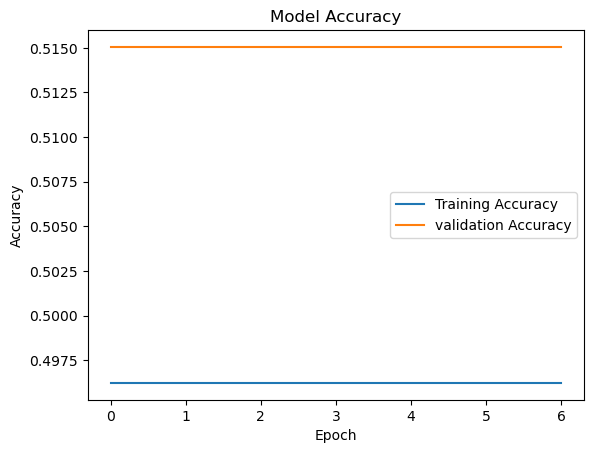

In [77]:
plt.plot(history.history['accuracy'],label = 'Training Accuracy')
plt.plot(history.history['val_accuracy'], label = 'validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()